# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install -U lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### Multiple LLM Backends
LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `text_gen` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python

from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", azure_endpoint=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(text_gen=text_gen)
```

Note that you can set your llm keys as follows

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```
#### Azure OpenAI
```python
from llmx import  llm, TextGenerationConfig
import os 

text_gen = llm(
    provider="openai",
    api_type="azure",
    azure_endpoint=os.environ["AZURE_OPENAI_BASE"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_version="2023-07-01-preview",
)
lida = Manager(text_gen=text_gen)
```


### Summarization Methods 
The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### Caching 
Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.


In [1]:
# set the transformers environment variable
import os
os.environ['XDG_CACHE_HOME']="/Users/yingding/MODELS"

In [2]:
# !pip install -U lida 
# !pip install lida[infographics] # for infographics support

In [17]:
from lida import Manager, TextGenerationConfig , llm

## Summarize Data, Generate Goals

In [18]:
import os, openai
from dotenv import load_dotenv, find_dotenv

# _ = load_dotenv(find_dotenv()) # read local .env file

# use the file .env_gpt4
_ = load_dotenv('.env') # read local .env file
# _ = load_dotenv('.env_gpt4') # read local .env file

# openai.api_key = os.environ['AZURE_OPENAI_API_KEY']
# openai.azure_endpoint = os.environ['AZURE_OPENAI_BASE']

# Uncomment to see the debug output of env variables
# print(f"""
# {os.environ['AZURE_OPENAI_API_KEY']}
# {os.environ['AZURE_OPENAI_BASE']}
# {os.environ["AZURE_OPENAI_API_KEY"]}
# {os.environ["API_VERSION"]}
# """)


In [19]:
# lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
text_gen = llm(provider="openai", 
               api_type="azure", 
               azure_endpoint=os.environ["AZURE_OPENAI_BASE"], 
               api_key=os.environ["AZURE_OPENAI_API_KEY"],    
               api_version=os.environ["API_VERSION"],
               ) # for azure openai
lida = Manager(text_gen = text_gen) # !! api key

tg_kwargs = {"model" : os.environ["MODEL"]}
textgen_config = TextGenerationConfig(n=1, temperature=0.5, use_cache=True, **tg_kwargs)


summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  

goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail_Price among different Types of cars?

**Visualization:** `Box plot of Retail_Price grouped by Type`

**Rationale:** By using a box plot, we can see the distribution of Retail_Price among different types of cars. This can give us insights into which types of cars are more expensive and the price range for each type. The 'Retail_Price' and 'Type' fields are used for this visualization because they can provide insights into the price distribution among different types of cars.



### Goal 1
---
**Question:** How does the Engine_Size__l_ correlate with the Horsepower_HP_?

**Visualization:** `Scatter plot of Engine_Size__l_ vs Horsepower_HP_`

**Rationale:** By using a scatter plot, we can see if there's a correlation between the engine size and the horsepower of the cars. This can give us insights into whether larger engines tend to have more horsepower. The 'Engine_Size__l_' and 'Horsepower_HP_' fields are used for this visualization because they can provide insights into the relationship between engine size and horsepower.


In [20]:
# goals can also be based on a persona 
persona = "a mechanic who wants to buy a car that is cheap but has good gas mileage"
personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail_Price for cars with good City_Miles_Per_Gallon?

**Visualization:** `Histogram of Retail_Price for cars where City_Miles_Per_Gallon is above average`

**Rationale:** This visualization uses the 'Retail_Price' and 'City_Miles_Per_Gallon' fields from the dataset. It will help the mechanic understand the cost range of cars with good gas mileage, which will aid in making an informed purchasing decision.



### Goal 1
---
**Question:** What is the relationship between Dealer_Cost and City_Miles_Per_Gallon?

**Visualization:** `Scatter plot of Dealer_Cost vs City_Miles_Per_Gallon`

**Rationale:** This visualization uses the 'Dealer_Cost' and 'City_Miles_Per_Gallon' fields from the dataset. It will help the mechanic understand if more fuel-efficient cars tend to be more expensive, which is crucial for budget planning.


## Generate Visualizations

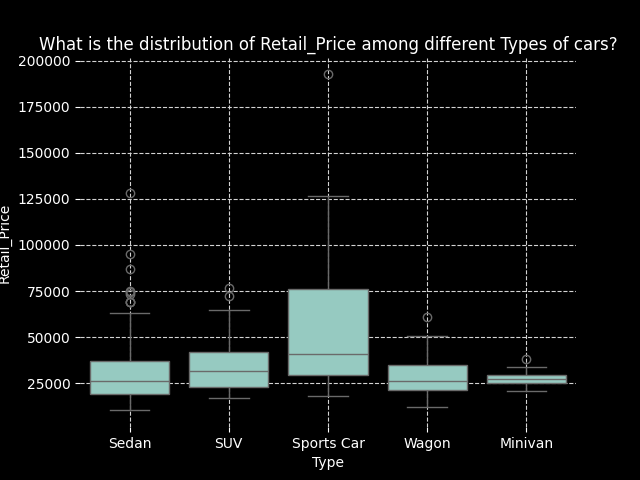

In [21]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True, **tg_kwargs)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

### Generate visualization via a "user query"   

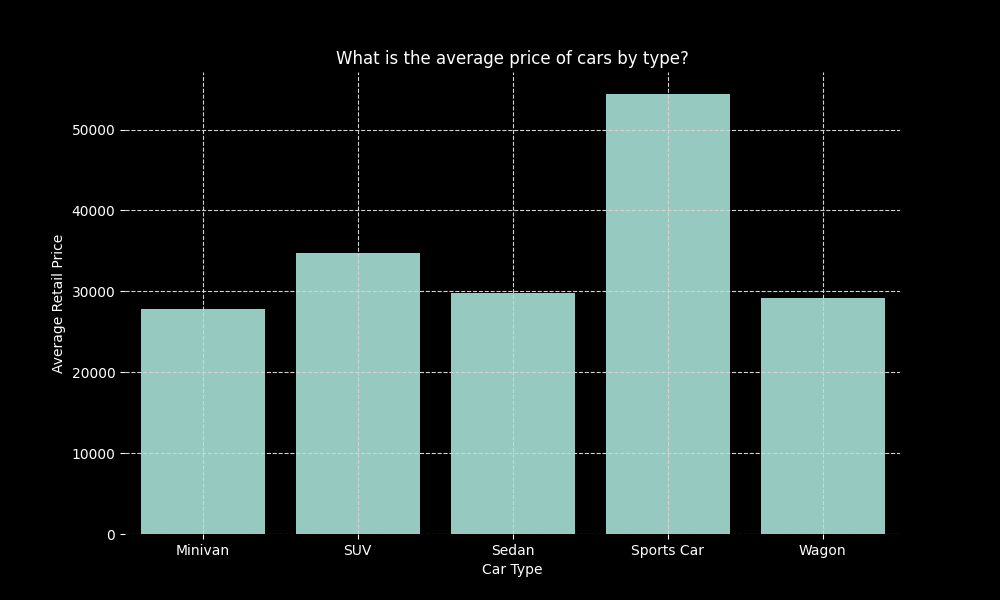

In [22]:
user_query = "What is the average price of cars by type?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True, **tg_kwargs)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

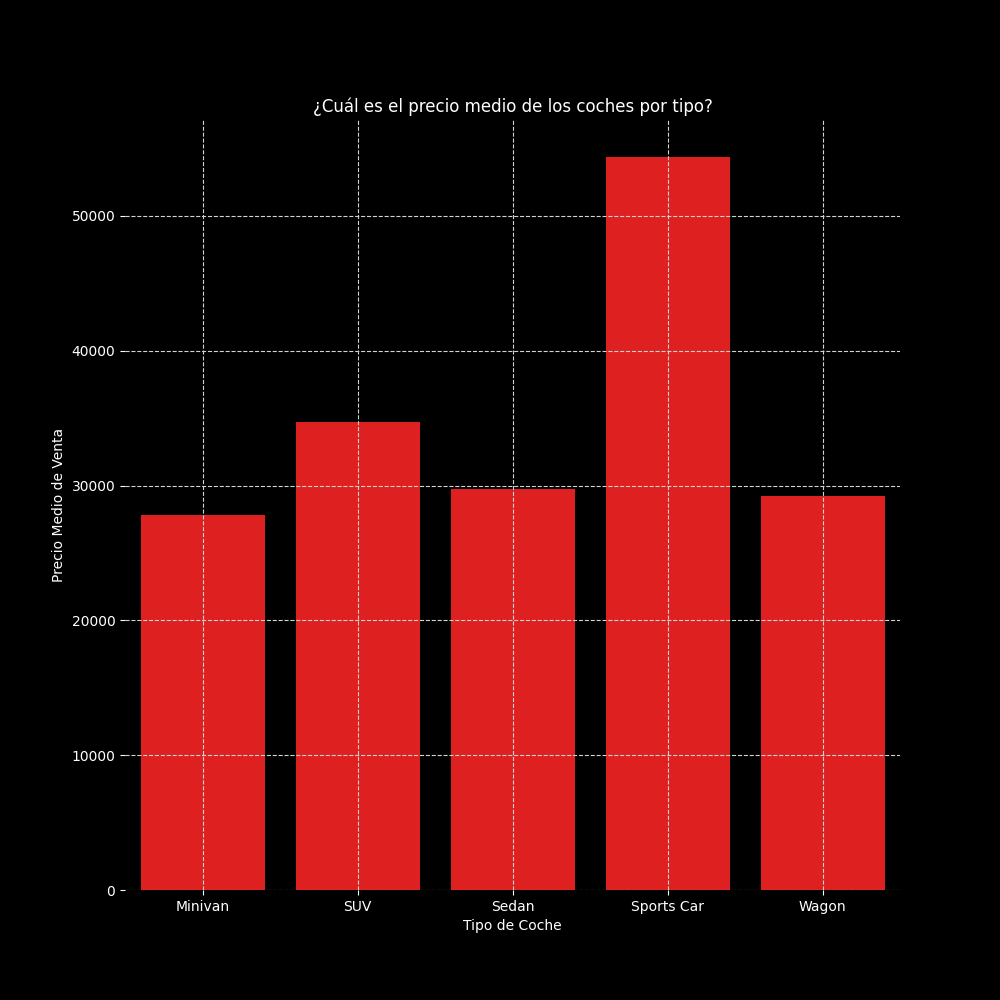

In [23]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True, **tg_kwargs)
instructions = ["make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [24]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  This section of the code is responsible for the physical appearance of the chart. The figure size is set to 10x6. The x-axis is labeled as 'Car Type' and the y-axis is labeled as 'Average Retail Price'. The title of the chart is 'What is the average price of cars by type?'. The chart is a bar chart, which is suitable for comparing the average price of different car types.
transformation  **  This section of the code is responsible for data transformation. The data is grouped by 'Type' and the mean of 'Retail_Price' for each type is calculated. The result is a new DataFrame with each row representing a car type and its average retail price.
visualization  **  This section of the code is responsible for creating the visualization. A bar plot is created using seaborn's barplot function. The x-axis represents the car type and the y-axis represents the average retail price. The data used for the plot is the transformed data 'avg_price_by_type'.


## Visualization code self-evaluation and repair

In [25]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code has no bugs, logic errors, syntax errors or typos. It compiles and runs successfully.
	**********************************
transformation Score 8 / 10
	 The data is transformed appropriately for the visualization type. The data is grouped by 'Type' and the mean 'Retail_Price' is calculated. However, the goal is to visualize the distribution of 'Retail
	**********************************
compliance Score 6 / 10
	 The code partially meets the specified visualization goals. It shows the average 'Retail_Price' for each 'Type' of car, but it does not show the distribution of 'Retail_Price' among different 'Types' 
	**********************************
type Score 6 / 10
	 A bar plot is not the best choice for visualizing the distribution of a variable. A boxplot or violin plot would be more appropriate for showing the distribution of 'Retail_Price' among different 'Typ
	**********************************
encoding Score 8 / 10
	 The data is encoded appropriately for

## Visualization Recommendation

In [26]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True, **tg_kwargs)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 2 charts


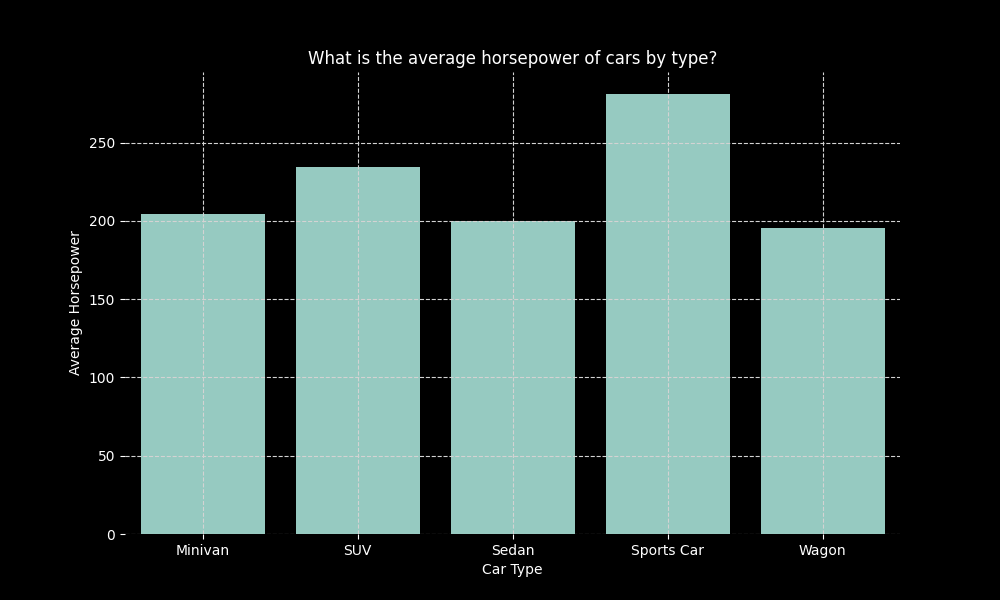

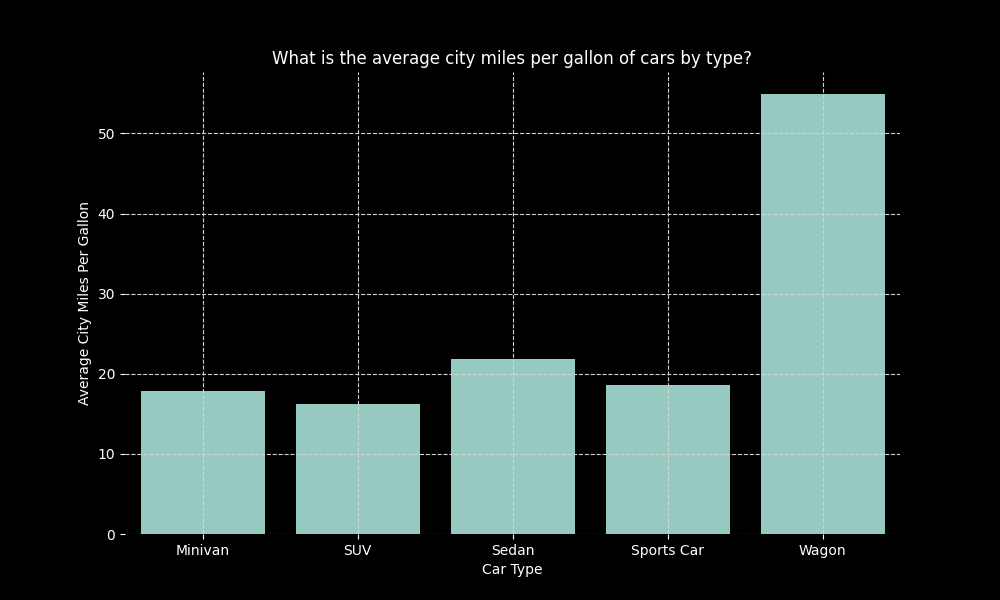

In [27]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [14]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [15]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background")

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

safety_checker/pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

(…)fusion_pytorch_model.non_ema.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from lida.utils import plot_raster
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 